<a href="https://colab.research.google.com/github/palomaalves/CNN/blob/main/lung_cancer_cnn_model_26_06_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Montando o Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile

arquivo_bd_zip = "/content/drive/MyDrive/7º período/Inteligência Artificial/Data.zip"

diretorio_destino = "/content/imagens"

with zipfile.ZipFile(arquivo_bd_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)

Mounted at /content/drive


#Importando as bibliotecas necessárias

In [ ]:
import gc
import os
import cv2
import json
import glob
import scipy
import shutil
import itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
from random import randint
from random import shuffle
from itertools import product
from functools import partial
from collections import Counter


import tensorflow.keras
import tensorflow as tf

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from distutils.dir_util import copy_tree, remove_tree

from keras import Model
from keras import layers
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, Model, load_model
from keras.applications import ResNet50, DenseNet201, InceptionV3
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from keras import Sequential, Input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator as IDG

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.0


#Pré-processamento de dados

In [ ]:
base_dir = "/content/imagens/Data/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
valid_dir = base_dir + "valid/"
work_dir = root_dir + "Data/"

transfer_train = "Data/train"
transfer_test = "Data/test"
transfer_valid = "Data/valid"

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, transfer_train)
copy_tree(test_dir, transfer_test)
copy_tree(valid_dir, transfer_valid)
print("Working Directory Contents:", os.listdir(train_dir))
print("Working Directory Contents:", os.listdir(test_dir))
print("Working Directory Contents:", os.listdir(valid_dir))

Working Directory Contents: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Working Directory Contents: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Working Directory Contents: ['normal', 'adenocarcinoma', 'squamous.cell.carcinoma', 'large.cell.carcinoma']


In [ ]:
os.makedirs('/content/Data_images/test')
os.makedirs('/content/Data_images/train')
os.makedirs('/content/Data_images/valid')

### Aumentando a quantidade de imagens do banco

In [ ]:
!pip install Augmentor

import Augmentor

t = Augmentor.Pipeline(train_dir)
v = Augmentor.Pipeline(valid_dir)

t.rotate(probability=1, max_left_rotation=0.15, max_right_rotation=0.15)
t.flip_left_right(probability=0.5)
t.zoom_random(probability=0.2, percentage_area=0.8)
t.status()

v.rotate(probability=1, max_left_rotation=0.15, max_right_rotation=0.15)
v.flip_left_right(probability=0.5)
v.zoom_random(probability=0.2, percentage_area=0.8)
v.status()

Initialised with 613 image(s) found.
Output directory set to /content/imagens/Data/train/output.Initialised with 315 image(s) found.
Output directory set to /content/imagens/Data/valid/output.Operations: 3
	0: RotateRange (probability=1 max_left_rotation=-1 max_right_rotation=1 )
	1: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	2: ZoomRandom (probability=0.2 percentage_area=0.8 randomise=False )
Images: 613
Classes: 4
	Class index: 0 Class label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib 
	Class index: 1 Class label: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa 
	Class index: 2 Class label: normal 
	Class index: 3 Class label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa 
Dimensions: 482
	Width: 434 Height: 261
	Width: 309 Height: 248
	Width: 396 Height: 216
	Width: 413 Height: 305
	Width: 425 Height: 279
	Width: 388 Height: 248
	Width: 437 Height: 262
	Width: 377 Height: 220
	Width: 847 Height: 533
	Width: 418 Height: 267
	Width: 366 Height: 229
	Width: 437 Height: 

In [ ]:
t.sample(1000)
t.process()

v.sample(1000)
v.process()

Processing <PIL.Image.Image image mode=RGBA size=384x245 at 0x7FA7C03C5EA0>: 100%|██████████| 1000/1000 [01:03<00:00, 15.67 Samples/s]
Processing <PIL.Image.Image image mode=RGBA size=373x239 at 0x7FA7C24F0E20>: 100%|██████████| 613/613 [00:34<00:00, 17.92 Samples/s]
Processing <PIL.Image.Image image mode=RGBA size=434x337 at 0x7FA872136530>: 100%|██████████| 1000/1000 [01:00<00:00, 16.57 Samples/s]
Processing <PIL.Image.Image image mode=RGBA size=424x326 at 0x7FA7C24BC760>: 100%|██████████| 315/315 [00:19<00:00, 15.97 Samples/s]


### Transferência de pastas

In [ ]:
import shutil

In [ ]:
def transferir_pasta(origem, destino):
    try:
        shutil.move(origem, destino)
        print("Pasta transferida com sucesso!")
    except Exception as e:
        print(f"Ocorreu um erro ao transferir a pasta: {e}")

In [ ]:
destino_train = "/content/Data_images/train"

origem_train = "/content/imagens/Data/train/output/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
transferir_pasta(origem_train, destino_train)

origem_train = "/content/imagens/Data/train/output/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
transferir_pasta(origem_train, destino_train)

origem_train = "/content/imagens/Data/train/output/normal"
transferir_pasta(origem_train, destino_train)

origem_train = "/content/imagens/Data/train/output/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
transferir_pasta(origem_train, destino_train)

Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!


In [ ]:
destino_test = "/content/Data_images/test"

origem_test = "/content/imagens/Data/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
transferir_pasta(origem_test, destino_test)

origem_test = "/content/imagens/Data/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
transferir_pasta(origem_test, destino_test)

origem_test = "/content/imagens/Data/test/normal"
transferir_pasta(origem_test, destino_test)

origem_test = "/content/imagens/Data/test/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
transferir_pasta(origem_test, destino_test)

Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!


In [ ]:
destino_valid = "/content/Data_images/valid"

origem_valid = "/content/imagens/Data/valid/output/adenocarcinoma"
transferir_pasta(origem_valid, destino_valid)

origem_valid = "/content/imagens/Data/valid/output/large.cell.carcinoma"
transferir_pasta(origem_valid, destino_valid)

origem_valid = "/content/imagens/Data/valid/output/normal"
transferir_pasta(origem_valid, destino_valid)

origem_valid = "/content/imagens/Data/valid/output/squamous.cell.carcinoma"
transferir_pasta(origem_valid, destino_valid)

Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!
Pasta transferida com sucesso!


In [ ]:
#Directories
base_dir = "/content/Data_images/"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
valid_dir = base_dir + "valid/"

print("Working Directory Contents:", os.listdir(train_dir))
print("Working Directory Contents:", os.listdir(test_dir))
print("Working Directory Contents:", os.listdir(valid_dir))

Working Directory Contents: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Working Directory Contents: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Working Directory Contents: ['normal', 'adenocarcinoma', 'squamous.cell.carcinoma', 'large.cell.carcinoma']


#Quantidade de Imagens em cada diretório

In [ ]:
# Definindo a quantidade de arquivos por pasta
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_dir)
valid_set = GetDatasetSize(valid_dir)
test_set = GetDatasetSize(test_dir)
print("Treino: ")
print(train_set,"\n\t")
print("validação: ")
print(valid_set,"\n\t")
print("Teste: ")
print(test_set,"\n\n")

Treino: 
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 505, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 305, 'normal': 399, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 404} 
	
validação: 
{'normal': 227, 'adenocarcinoma': 488, 'squamous.cell.carcinoma': 384, 'large.cell.carcinoma': 216} 
	
Teste: 
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 




#DataGenerator

In [ ]:
#Labels
CLASSES = [ 'Adenocarcinoma',
            'large,cell.carcinoma',
            'Normal',
            'squamous.carcinoma']

IMG_SIZE = 299
IMAGE_SIZE = [299, 299]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Performing ImageDataGenerator

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=train_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 1613 images belonging to 4 classes.


In [ ]:
#Performing ImageDataGenerator

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

test_data_gen = work_dr.flow_from_directory(directory=test_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 72 images belonging to 4 classes.


In [ ]:
#Performing ImageDataGenerator

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

valid_data_gen = work_dr.flow_from_directory(directory=valid_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 1315 images belonging to 4 classes.


Exemplos das Imagens de treino

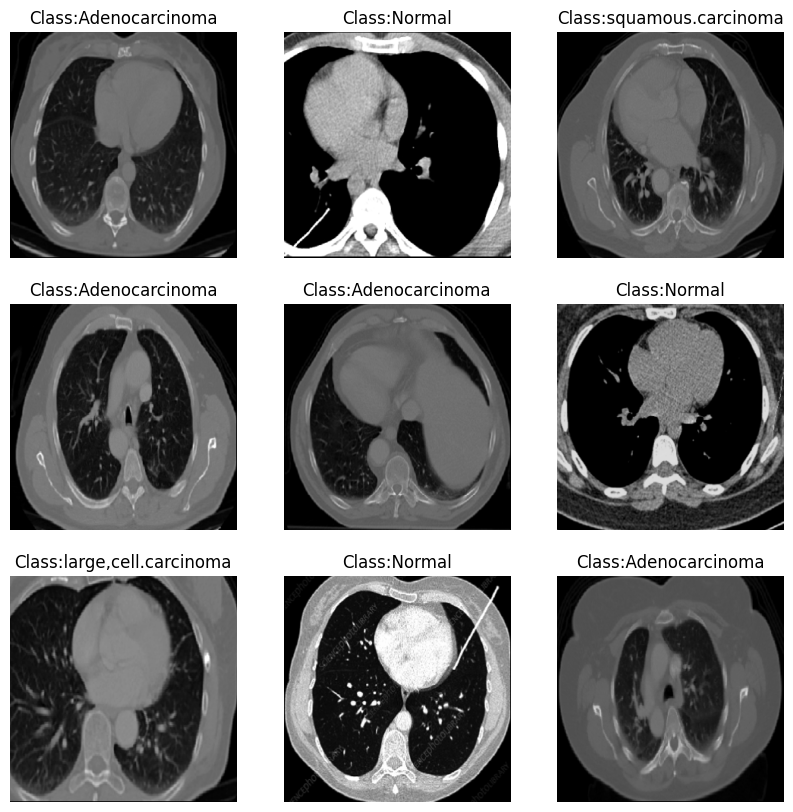

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1613)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("on")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_data_gen)

In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(1613, 299, 299, 3) (1613, 4)


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

test_data, test_labels = test_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(test_data.shape, test_labels.shape)

(72, 299, 299, 3) (72, 4)


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

valid_data, valid_labels = valid_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(valid_data.shape, valid_labels.shape)

(1315, 299, 299, 3) (1315, 4)


In [ ]:
#Contagem das Imagens de Treino (total 1.613)
imgs = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa','normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
counter = {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib':0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa':0, 'normal':0, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa':0}
DIR = "/content/Data_images/train/"

for image in imgs:
  for count in glob.iglob(DIR+image+"/*"):
    counter[image] += 1

counter

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 505,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 305,
 'normal': 399,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 404}

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2020, 299, 299, 3) (2020, 4)


#Modelo

### Using the InceptionV3 model as a base model for the task

In [ ]:
K.clear_session()
gc.collect()

22554

In [ ]:
inception_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
mc1 = ModelCheckpoint(
    filepath="./best_model_a.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc1];

In [ ]:
CALLBACKS = [mc1]

custom_inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics = ['accuracy'])

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

#Treino

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 10

history = custom_inception_model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.4079
Epoch 1: val_accuracy improved from -inf to 0.48745, saving model to ./best_model_a.hdf5
64/64 [==============================] - 48s 431ms/step - loss: 1.3912 - accuracy: 0.4079 - val_loss: 1.0325 - val_accuracy: 0.4875
Epoch 2/10
63/64 [============================>.] - ETA: 0s - loss: 1.0736 - accuracy: 0.5332
Epoch 2: val_accuracy improved from 0.48745 to 0.51179, saving model to ./best_model_a.hdf5
64/64 [==============================] - 16s 254ms/step - loss: 1.0751 - accuracy: 0.5327 - val_loss: 0.9494 - val_accuracy: 0.5118
Epoch 3/10
63/64 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.6136
Epoch 3: val_accuracy improved from 0.51179 to 0.64487, saving model to ./best_model_a.hdf5
64/64 [==============================] - 23s 369ms/step - loss: 0.8889 - accuracy: 0.6134 - val_loss: 0.8513 - val_accuracy: 0.6449
Epoch 4/10
63/64 [============================>.]

#Resultados

### Tabulating the Results of our custom InceptionV3 model

In [ ]:
model_incep = load_model("./best_model_a.hdf5")

In [ ]:
# Abre o arquivo json e formata para string
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<Axes: >

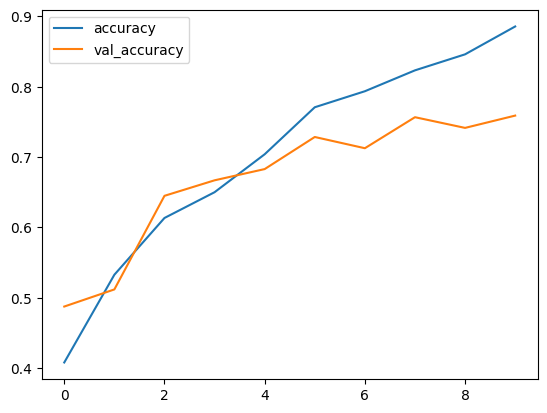

In [ ]:
# Mostra o gráfico de acurácia
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

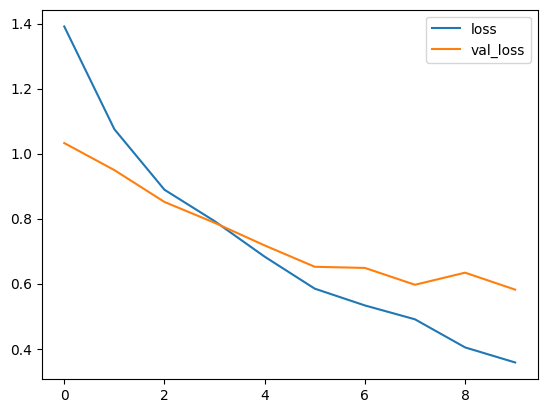

In [ ]:
# Mostra o gráfico de perda
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

3/3 [==============================] - 2s 839ms/step - loss: 0.4495 - accuracy: 0.8750
Testing Accuracy: 87.50%


In [ ]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

3/3 [==============================] - 2s 139ms/step


In [ ]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                      precision    recall  f1-score   support

      Adenocarcinoma       0.95      0.83      0.88        23
large,cell.carcinoma       0.95      0.86      0.90        21
              Normal       1.00      1.00      1.00        13
  squamous.carcinoma       0.65      0.87      0.74        15

           micro avg       0.88      0.88      0.88        72
           macro avg       0.89      0.89      0.88        72
        weighted avg       0.90      0.88      0.88        72
         samples avg       0.88      0.88      0.88        72



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels, average='weighted')
recall = recall_score(test_labels, pred_labels, average='weighted')
f1 = f1_score(test_labels, pred_labels, average='weighted')

# Print results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1 * 100))

Accuracy: 87.50%
Precision: 89.58%
Recall: 87.50%
F1-Score: 88.01%


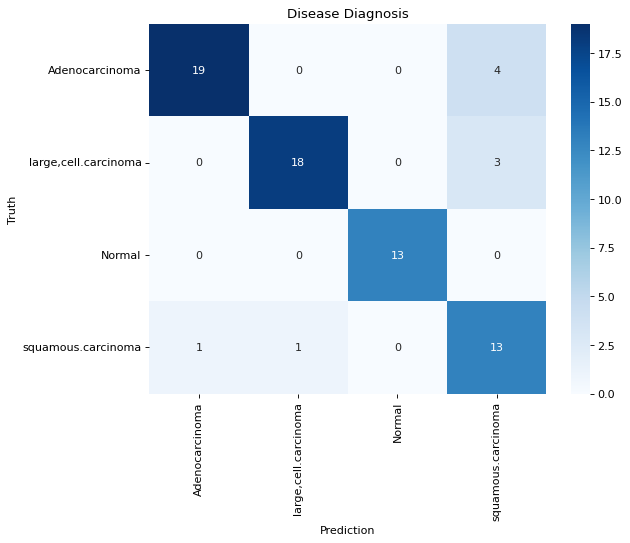

In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 88.75 %
Matthew's Correlation Coefficient: 83.61 %


In [ ]:
#Saving the model for future use

custom_inception_model_dir = os.path.join(work_dir, "inception_cnn_model.h5")
custom_inception_model.save(custom_inception_model_dir)

print(os.listdir(work_dir))

['inception_cnn_model.h5', 'valid', 'train', 'test']


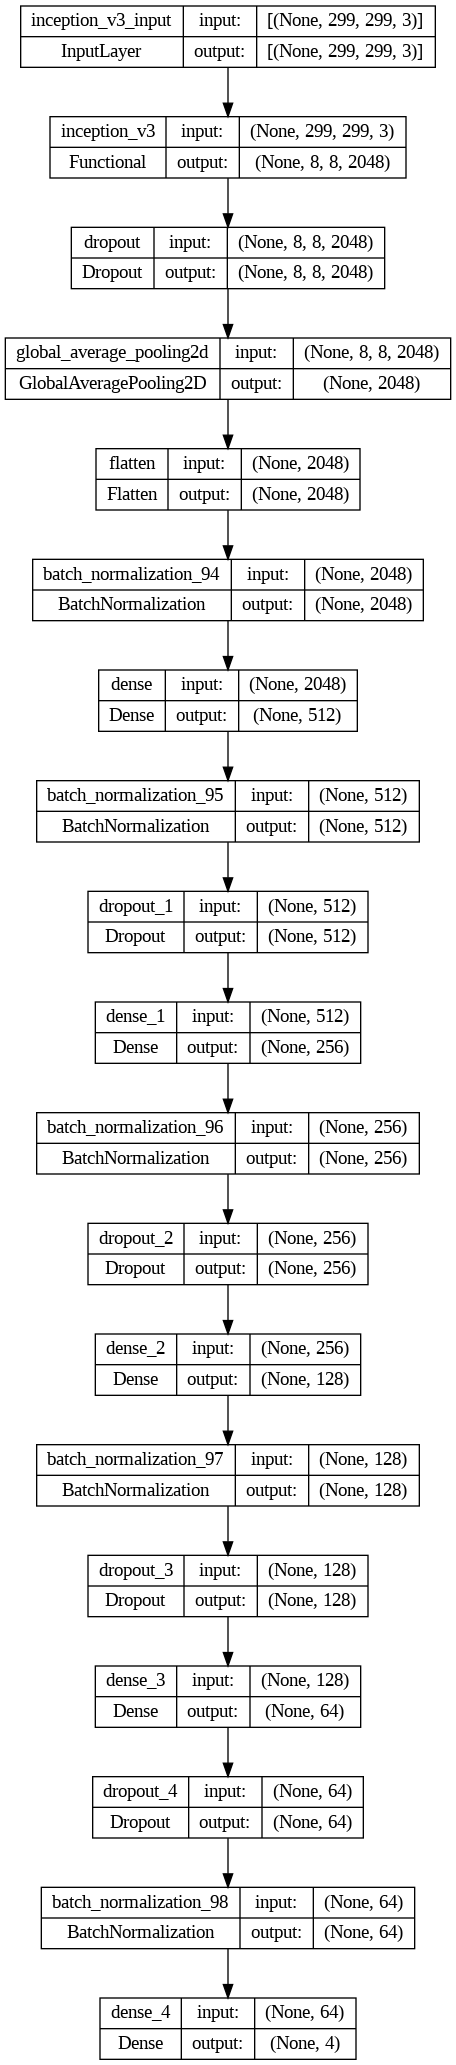

In [ ]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

# Transferindo o modelo para o Drive

In [ ]:
source_file = '/content/Data/inception_cnn_model.h5'
destination_folder = '/content/drive/MyDrive/7º período/Inteligência Artificial'

shutil.move(source_file, destination_folder)

'/content/drive/MyDrive/7º período/Inteligência Artificial/inception_cnn_model.h5'